<h1><center>CS5200 Computer Architecture - Project 1</center></h1>
<h3><center>Authors: Smita Khapre, Carlos Torres and Kevin Cardenas</center></h3>

In this project we used the gem5 simulator to run an experiment changing features of the pipeline, functional units, and compiler optimization (loop unrolling) and evaluated the sensitivity of changing these features. Multiple response variables were collected to evaluate the performance of the different combinations of features. These responses are simulation time, L1 cache misses, and the number of times a loop was unrolled. 
- **CPU:** TimeSimpleCPU, X86MinorCPU
- **Cache Sizes:** 64kB Direct-Mapped L1 Data Cache, 32kB Direct-Mapped L1 Instruction Cache, 4MB 8-way Unified L2 Cache
- **Functional Units (Operation Latency, Issue Latency):** (6, 1), (5, 2), (4, 3), (3, 4), (2, 5), (1, 6)
- **Loop Unrolling:** Not Included, Included

Additionally, each of these architectures were run using two implementations of a priority queue:
- `pq-linklist.c`
- `pq-minheap.c`

In [1]:
import read_data
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_rows', None)

## 1. Import Data
A bash script was utilized to run all of the configurations of our simulation. This script also included functionality to create and save the `stats.txt` files in a file structure. After running all of the experiments in gem5, the file structure containing all of the `stats.txt` output files was copied from the Docker container. A second script was created to read in the `stats.txt` files contained in the file structure and save the data into a pandas DataFrame.

In [2]:
df1, df2, df = read_data.read_data()
df1.head()

,pq,n,op_class,value
0,linklist,10000,No_OpClass,634188
1,minheap,10000,No_OpClass,672606
2,linklist,10000,IntAlu,241880161
3,minheap,10000,IntAlu,46699328
4,linklist,10000,IntMult,100746


In [3]:
df2.head()

,pq,n,part,op_class,value
0,linklist,1000,a,No_OpClass,3161
1,linklist,1000,b,No_OpClass,3002
2,linklist,1000,c,No_OpClass,48320
3,linklist,10000,a,No_OpClass,30164
4,linklist,10000,b,No_OpClass,30008


In [4]:
df.head()

,time,l1d_miss,l1i_miss,l2_miss,l1d_latency,l1i_latency,l2_latency,cpi,part,fu,op_lat,pq,n
0,0.000004,0.010742,0.003040,0.888889,5.135000e+05,231000.0,585000.0,2.939729,p3,default,default,linklist,10
1,0.002584,0.006735,0.000004,0.143879,9.829350e+07,230500.0,41041500.0,3.012804,p3,default,default,linklist,1000
2,0.524850,0.509545,0.000000,0.000192,3.401131e+11,330000.0,435255500.0,6.851699,p3,default,default,linklist,10000
3,0.000004,0.010742,0.003040,0.888889,5.135000e+05,231000.0,585000.0,2.939729,p3,6_1,default,linklist,10
4,0.002584,0.006735,0.000004,0.143879,9.829350e+07,230500.0,41041500.0,3.012804,p3,6_1,default,linklist,1000


## 2. Instruction Breakup
### Question 1: What is the breakup of instructions? 
Part 1 and Part 2 (`p1` and `p2`, respectively) were both run to provide baseline results using the TimingSimpleCPU, the baseline functional units (1 operation latency and 1 issue latency), and without using any cache. The only difference between the two parts is that `p1` tracked the descriptive statistics for the entire program, where `p2` simply tracked the statistics for the sorting portion of the program. In order to quickly inspect the breakup of instructions for each of our priority queue implementations, a bar plot was used. These plots compare the instruction breakup of `p1` and `p2` for each priority queue type.

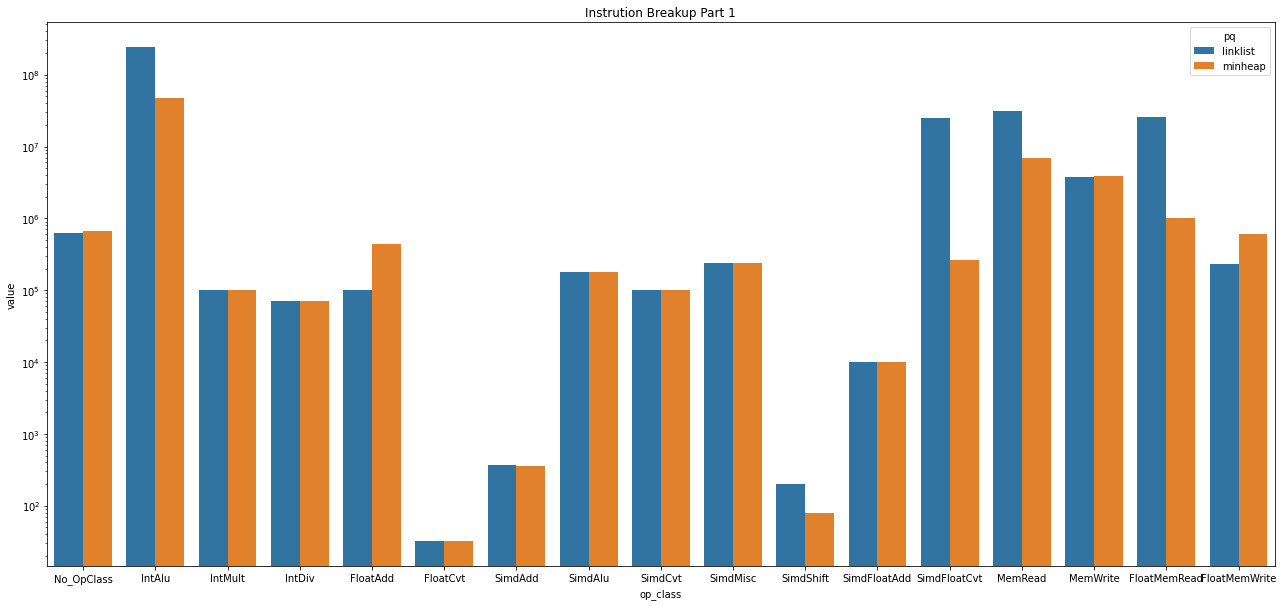

In [5]:
plt.rcParams["figure.figsize"] = (22, 10)
sns.barplot(data=df1, x='op_class', y='value', hue='pq', log=True)
plt.title("Instrution Breakup Part 1")
plt.show()

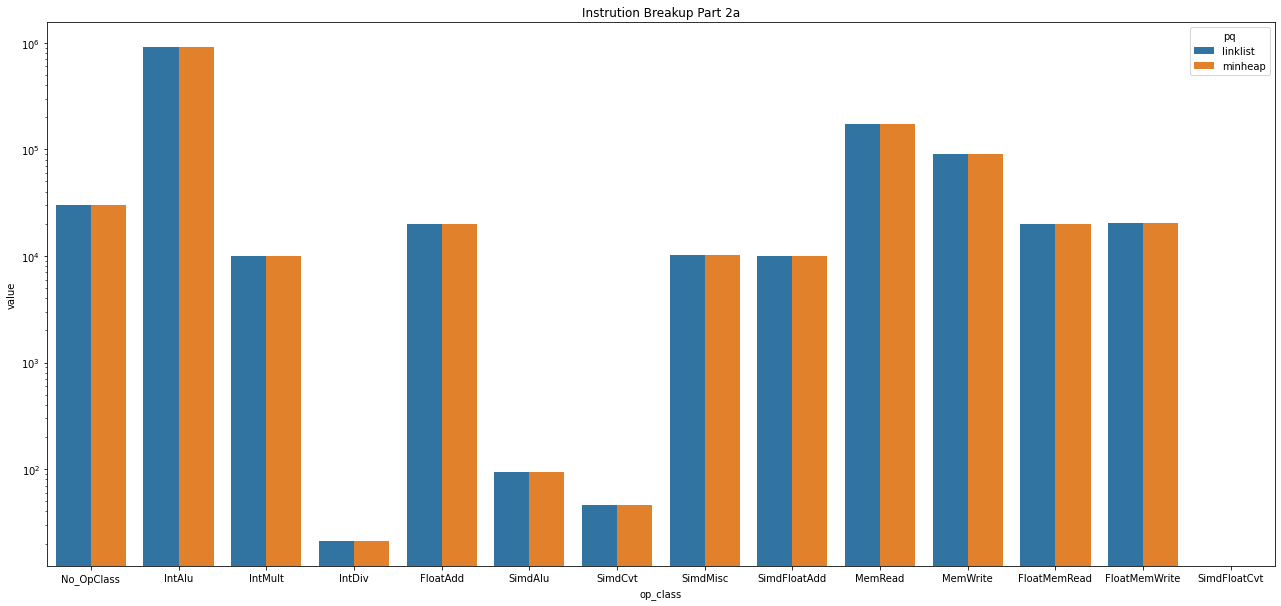

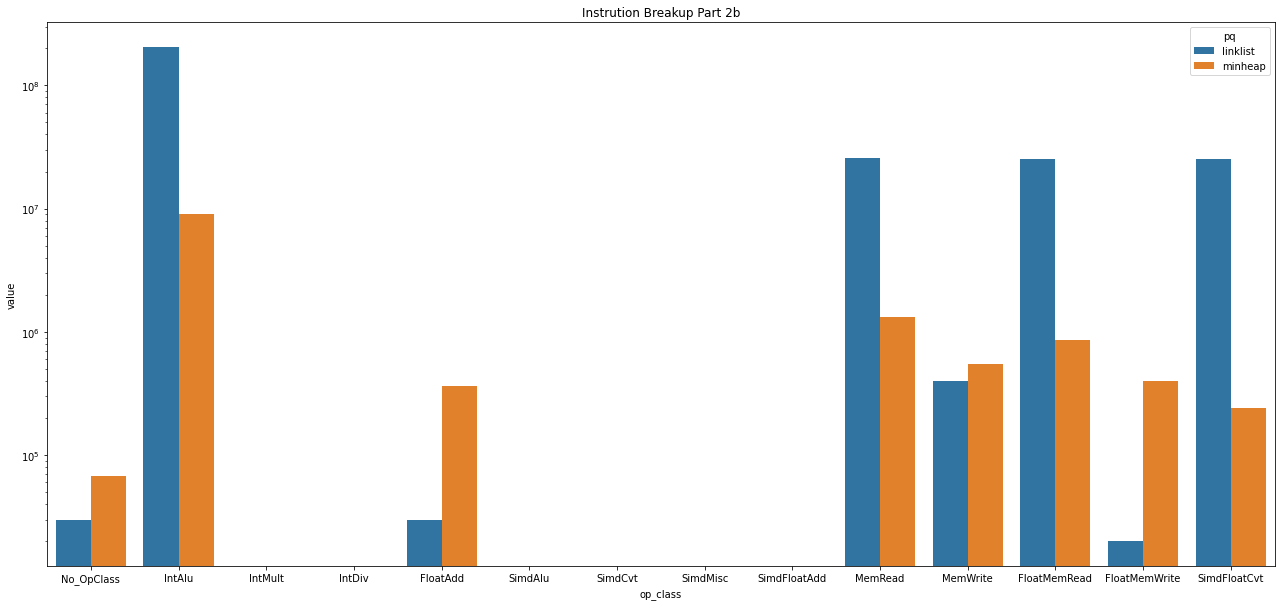

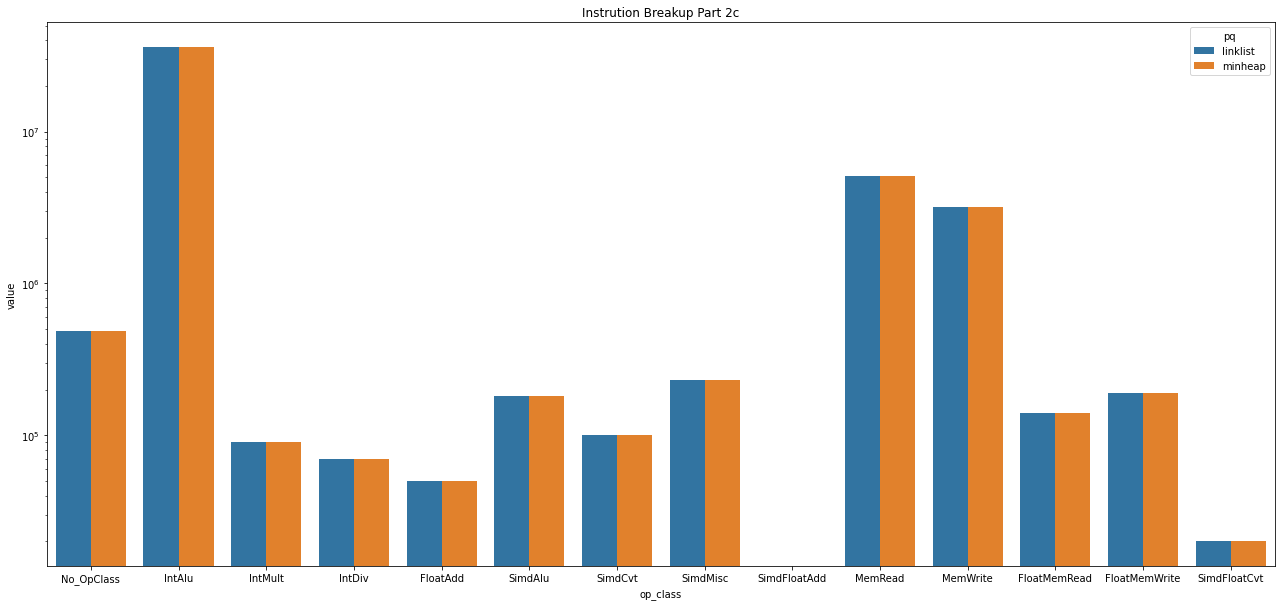

In [6]:
for part in df2.part.unique():
    q1b = df2.loc[(df2.n == 10000) & (df2.part == part)]
    sns.barplot(data=q1b, x='op_class', y='value', hue='pq', log=True)
    plt.title("Instrution Breakup Part 2" + part)
    plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

## 3. Pipeline Design Exploration
### Question 2: What are the L1 Cache Miss Rates?
In this next part, `p3`, we move away from the TimingSimpleCPU which does not use a pipeline to the X86MinorCPU which executes instructions in a pipelined fashion. Part 3 also adds cache to the architecture: 64kB Direct-Mapped L1 Data Cache, 32kB Direct-Mapped L1 Instruction Cache, 4MB 8-way Unified L2 Cache. An easy way to observe the sensitivity of changing memory technology is to use a bar plot. An easy way to observe the cache miss rates for each of the priority queue implementations is to use a bar plot. **NOTE: These plots use a log scale on the y-axis.**

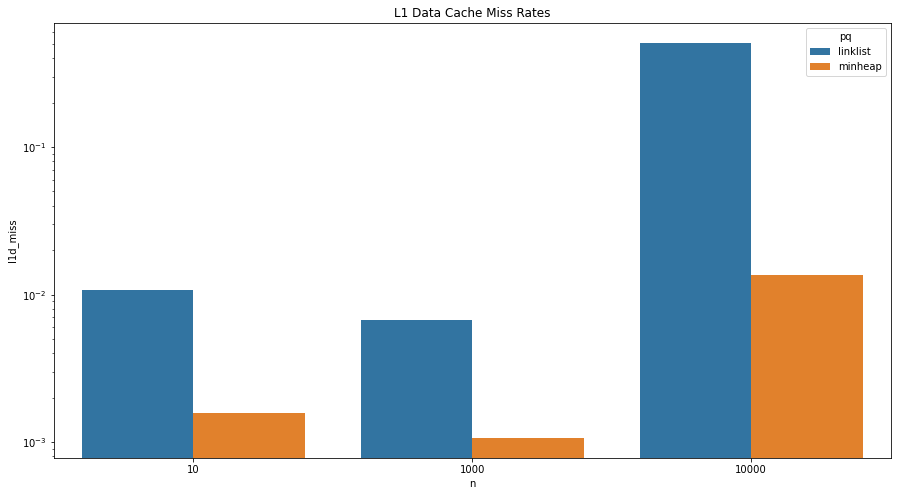

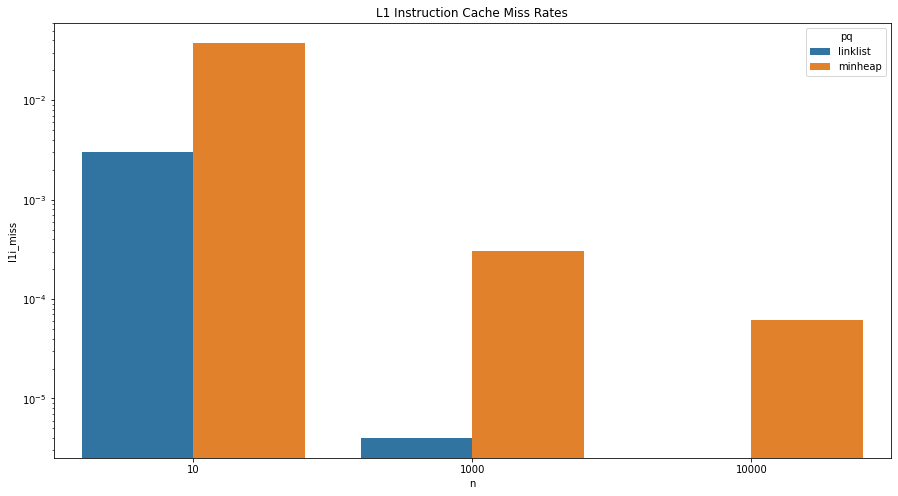

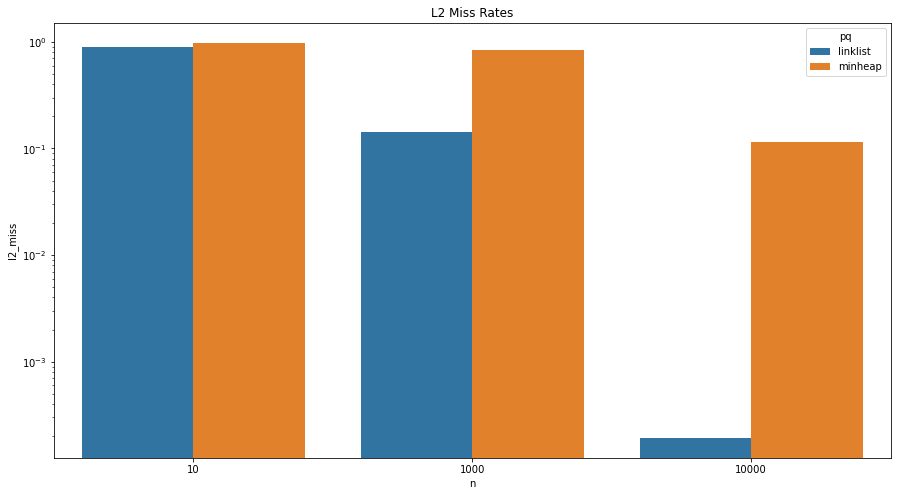

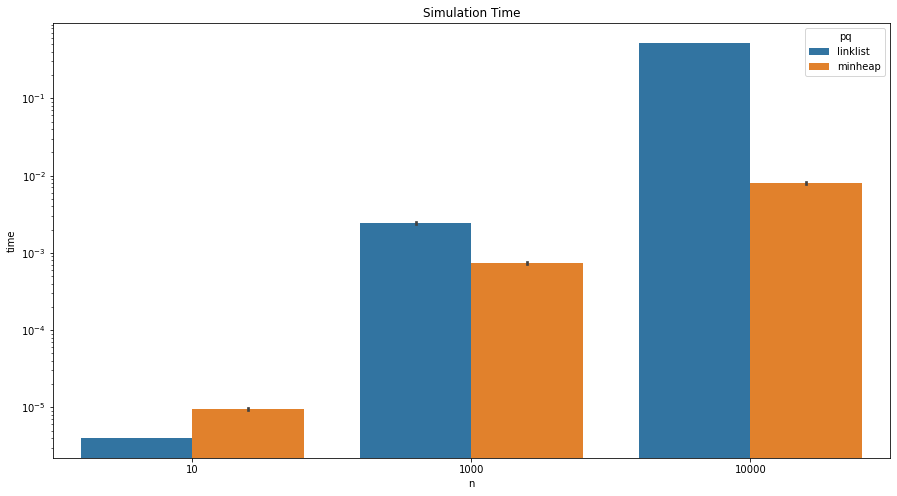

In [17]:
plt.rcParams["figure.figsize"] = (15, 8)
df3 = df.loc[df.part=='p3']
sns.barplot(data=df3, x='n', y='l1d_miss', hue='pq', log=True)
plt.title("L1 Data Cache Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='l1i_miss', hue='pq', log=True)
plt.title("L1 Instruction Cache Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='l2_miss', hue='pq', log=True)
plt.title("L2 Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='time', hue='pq', log=True)
plt.title("Simulation Time")
plt.show()

It is apparent that `minheap` L1 data cache miss rate is significantly less than the `linklist` implementation. Additionally, the number of total L1 data cache accesses in the `minheap` implementation is a mere fraction compared to `linklist`, shown in the table below. Although `minheap` has a higher L1 instruction cache miss rate in the second plot, the count of instruction misses is a small fraction of the number of data misses. The ratio of L1 intruction cache misses to L1 data cache misses for `minheap` is shown in the table below. Due to this extremely low ratio, the higher L1 instruction cache miss rate is less significant compared to the L1 data cache miss rate. Lastly, although `linklist` had a lower L2 cache miss rate, the count of `linklist` L2 cache misses is larger than the number of `minheap` L2 cache misses, which indicates that `linklist` simply accessed the L2 cache more.

| Cache Type | linklist | minheap |
| --- | --- | --- |
| L1 Data Accesses | 51,280,937 | 3,262,253 |
| L1 Instruction/Data Miss Ratio | 1.9e-7 | 2.5e-3 |
| L2 Unified Accesses | 5,004 | 4,659 |

One interesting thing to note is that for small input values (`n` = 10), the `linklist` implementation runs faster than `minheap`. However, each of the cache miss observations above, coupled with the significant time savings for large `n`, we conclude that the `minheap` implementation performs better than the `linklist` data structure. 

### Question 3: Which Design of the FloatSimd Functional Unit Would you Prefer?
For this question we will assume that the issueLat and the opLat of the FloatSimdFU can vary from 1 to 6 cycles and that they always sum to 7 cycles. For each decrease in the opLat, we need to pay with a unit increase in issueLat. The enumerated combinations are:
- opLat = 6, issueLat = 1
- opLat = 5, issueLat = 2
- opLat = 4, issueLat = 3
- opLat = 3, issueLat = 4
- opLat = 2, issueLat = 5
- opLat = 1, issueLat = 6

We ran our simulation using `n` = 10000.

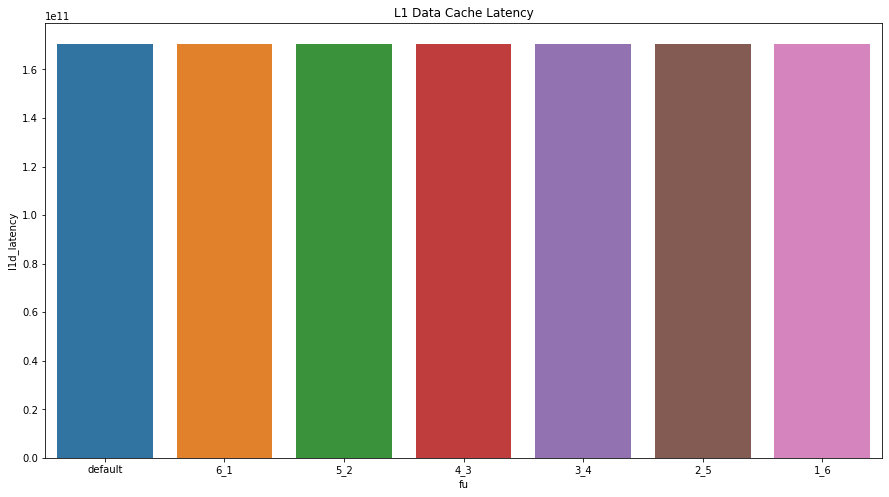

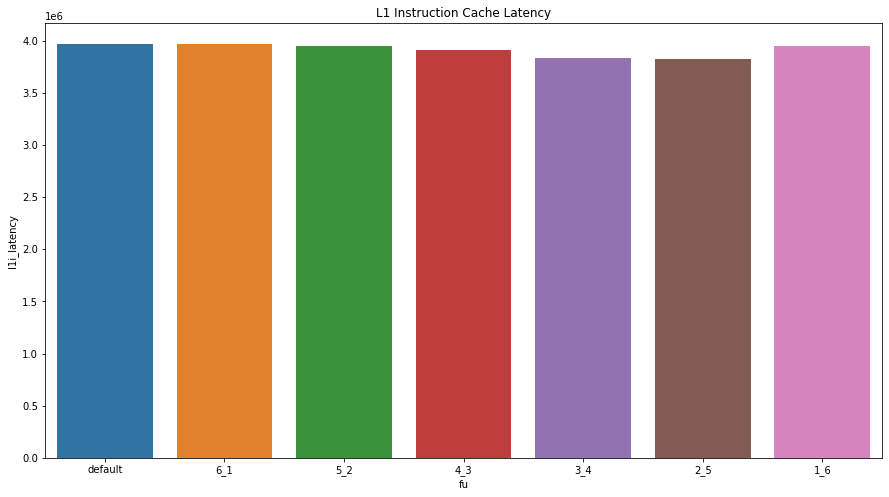

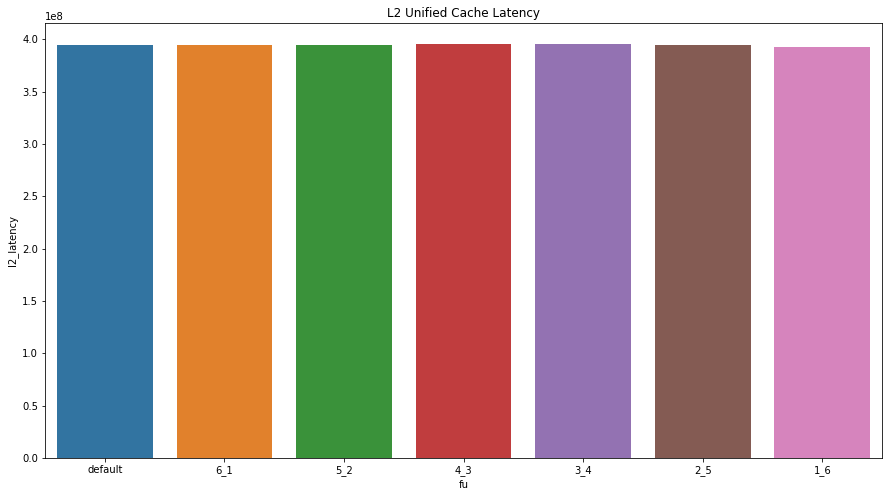

In [14]:
q3 = df3.loc[df3.n == 10000]
sns.barplot(data=q3, x='fu', y='l1d_latency', ci=None)
plt.title("L1 Data Cache Latency")
plt.show()
sns.barplot(data=q3, x='fu', y='l1i_latency', ci=None)
plt.title("L1 Instruction Cache Latency")
plt.show()
sns.barplot(data=q3, x='fu', y='l2_latency', ci=None)
plt.title("L2 Unified Cache Latency")
plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

## 4. Function Unit Design Tradeoffs

### Question 4: Which Function Cycles Should we Halve?
In order to answer this question, we will assume our original Minor CPU design requires 2 cycles for integer functions and 4 cycles for floating point functions operation latencies (opLat). In our upcoming Minor CPU, we can halve either of these latencies: integer or floating point. The issue latency will remain constant at the default of 1. The enumerated combinations are:
- Int = 2 cycles, FP = 4 cycles (this will be our baseline)
- Int = 1 cycles, FP = 4 cycles 
- Int = 2 cycles, FP = 2 cycles

In [10]:
q4

,time,l1d_miss,l1i_miss,l2_miss,l1d_latency,l1i_latency,l2_latency,cpi,part,fu,op_lat,pq,n
21,0.522114,0.509545,0.000000,0.000192,3.401258e+11,344000.0,440563500.0,6.815976,p4,default,2_4,linklist,10000
22,0.522160,0.509530,0.000000,0.000192,3.401191e+11,330500.0,438445500.0,6.816586,p4,default,1_4,linklist,10000
23,0.519136,0.509545,0.000000,0.000192,3.401193e+11,452500.0,437427500.0,6.777098,p4,default,2_2,linklist,10000
45,0.008430,0.013476,0.000062,0.113712,1.021266e+09,7300500.0,348061500.0,2.067272,p4,default,2_4,minheap,10000
46,0.008295,0.013411,0.000062,0.113733,1.026370e+09,7477500.0,352477000.0,2.034032,p4,default,1_4,minheap,10000
47,0.008543,0.013464,0.000062,0.113712,1.021691e+09,7514000.0,350213000.0,2.094961,p4,default,2_2,minheap,10000


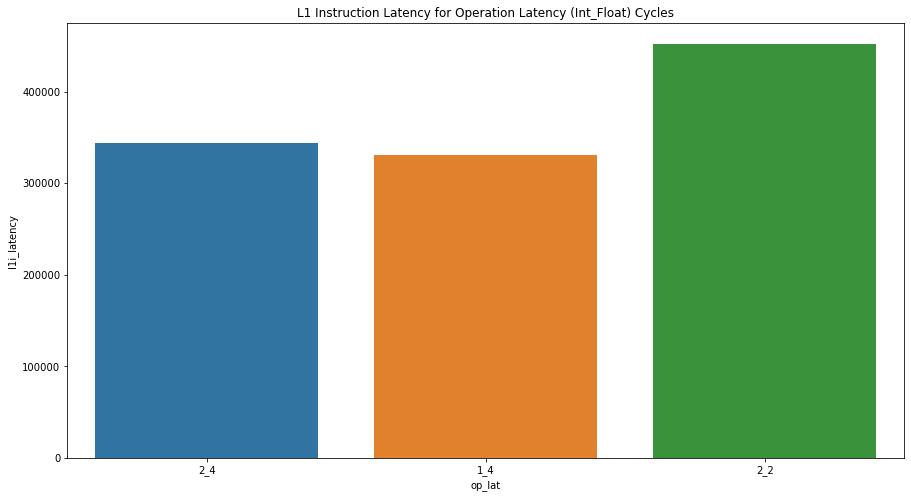

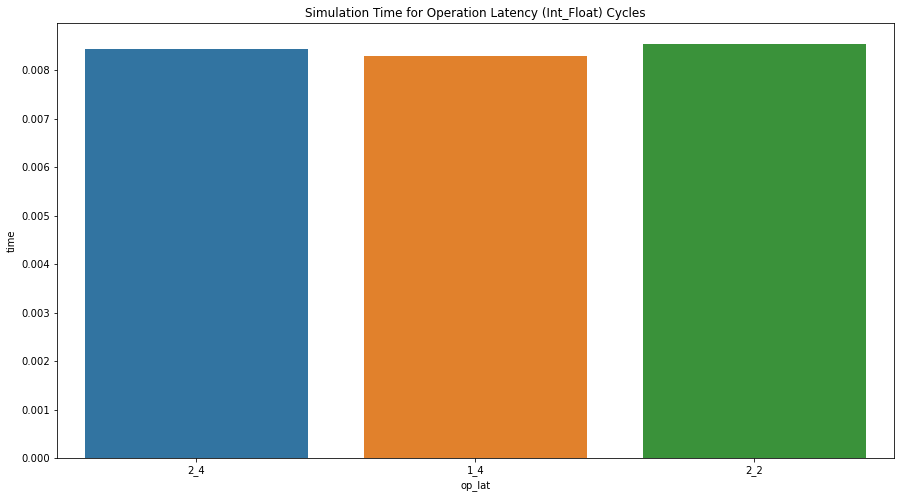

In [32]:
q4 = df.loc[df.part == 'p4']
sns.barplot(data=q4.loc[q4.pq=='linklist'], x='op_lat', y='l1i_latency')
plt.title("L1 Instruction Latency for Operation Latency (Int_Float) Cycles")
plt.show()
sns.barplot(data=q4.loc[q4.pq=='minheap'], x='op_lat', y='time')
plt.title("Simulation Time for Operation Latency (Int_Float) Cycles")
plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

## 5. Compiler Optimization
### Question 5: How Many Times Were Loops Unrolled?
A popular way to optimize a compiler is to reduce loop overhead by using loop unrolling. In this section we will examine how many times the loops in `main.c` are unrolled, as well as inspecting whether or not the loops in any of the `pq-*.c` implementations get unrolled.

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

## 6. Repeat Parts 3 and 4 using Loop Unrolling
### Questions 6: How does Loop Unrolling Affect Performance of this Implementation of the Sort Loop?
The primary aspect we will analyze to see the affect of loop unrolling is the L1 cache miss rates for each of the `pq-*.c` implementations.

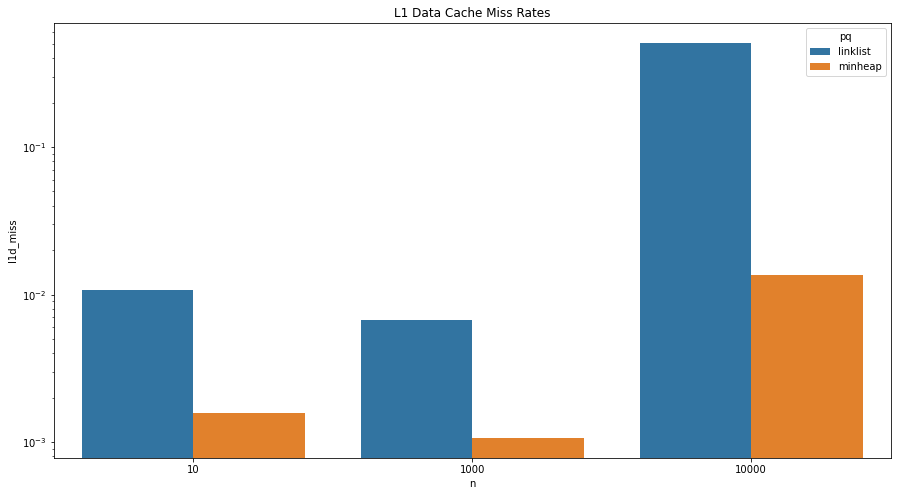

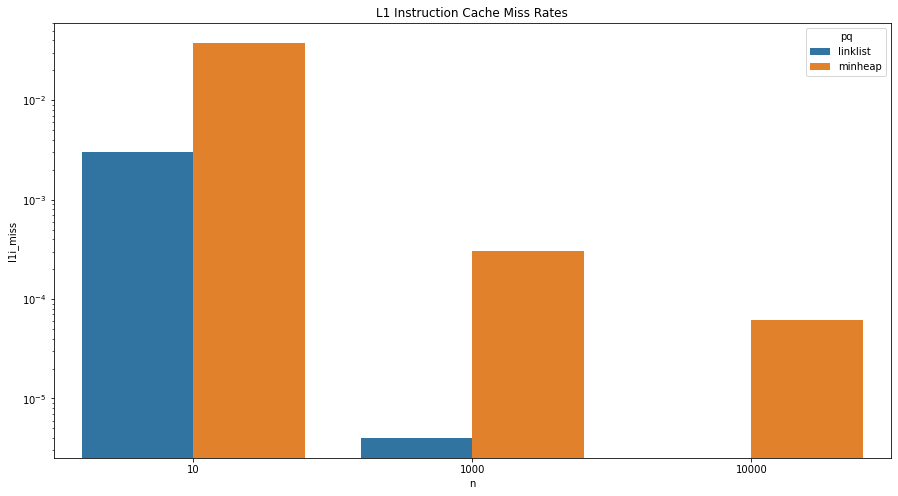

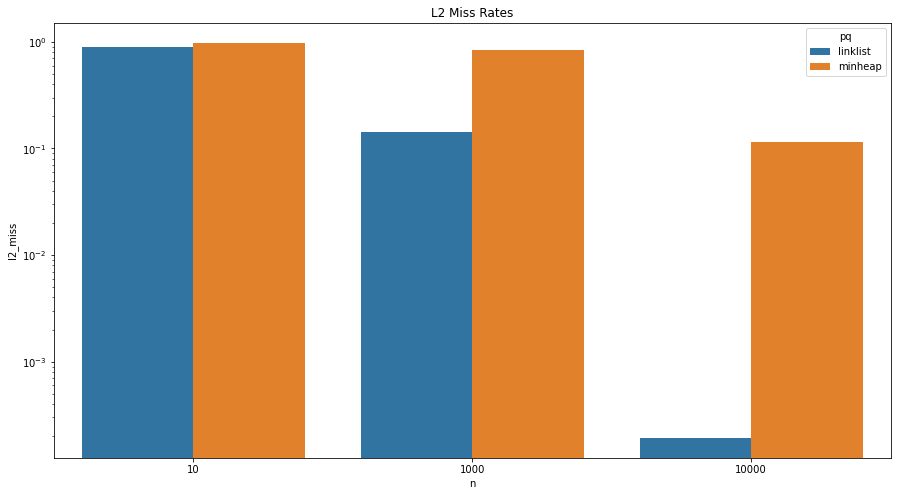

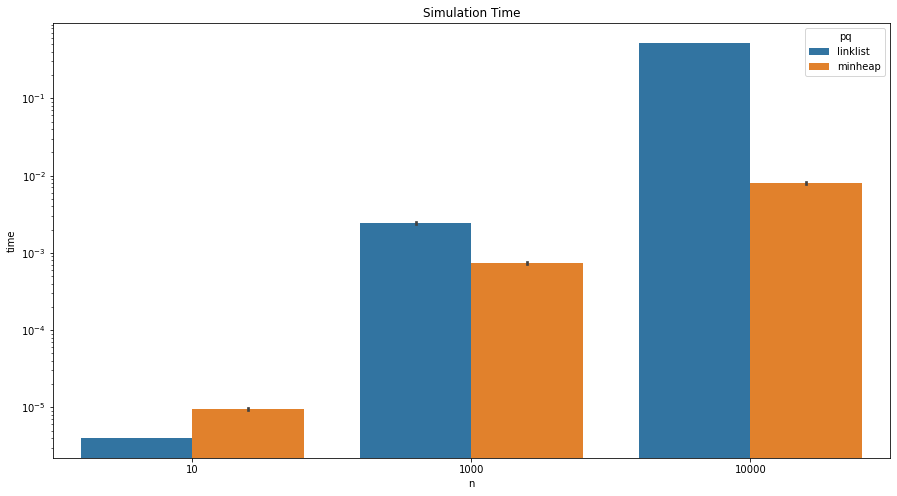

In [33]:
plt.rcParams["figure.figsize"] = (15, 8)
df5 = df.loc[df.part=='p3']
sns.barplot(data=df3, x='n', y='l1d_miss', hue='pq', log=True)
plt.title("L1 Data Cache Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='l1i_miss', hue='pq', log=True)
plt.title("L1 Instruction Cache Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='l2_miss', hue='pq', log=True)
plt.title("L2 Miss Rates")
plt.show()
sns.barplot(data=df3, x='n', y='time', hue='pq', log=True)
plt.title("Simulation Time")
plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

### Question 7: Do any Design Choices Change due to Loop Unrolling?
We conducted additional simulations with loop unrolling to examine whether or not our design choices change for the operation
and issue latency tradeoff, as well as the opportunity to halve either the integer or floating point operation latency. To summarize the combinations, the tradeoff combinations of operation and issue latency are:
- opLat = 6, issueLat = 1
- opLat = 5, issueLat = 2
- opLat = 4, issueLat = 3
- opLat = 3, issueLat = 4
- opLat = 2, issueLat = 5
- opLat = 1, issueLat = 6

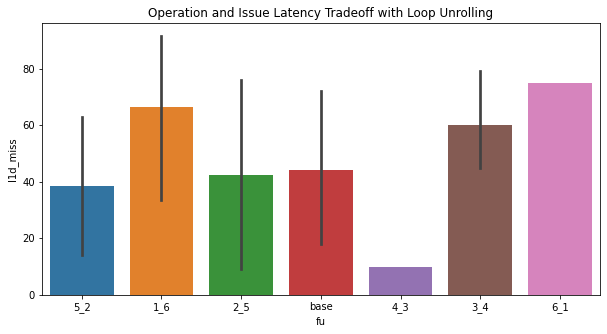

In [17]:
sns.barplot(data=q5, x='fu', y='l1d_miss')
plt.title("Operation and Issue Latency Tradeoff with Loop Unrolling")
plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************

The options for halving operation latencies are:
- Int = 2 cycles, FP = 4 cycles (this will be our baseline)
- Int = 1 cycles, FP = 4 cycles 
- Int = 2 cycles, FP = 2 cycles

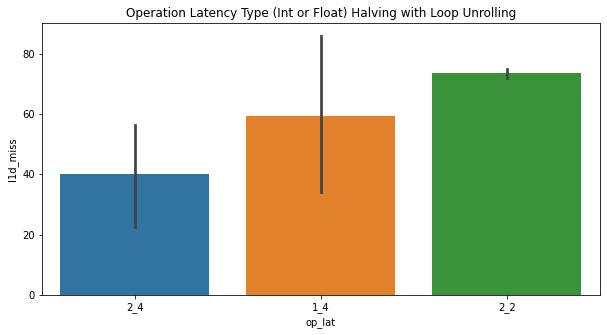

In [18]:
sns.barplot(data=q5, x='op_lat', y='l1d_miss')
plt.title("Operation Latency Type (Int or Float) Halving with Loop Unrolling")
plt.show()

*******************************************************************************************
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**ENTER RESULTS CONVERSAION HERE**

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
*******************************************************